In [1]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np

In [2]:
%run ../shared_functions.py

In [3]:
%run ../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [4]:
DIR_INPUT = '../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 328 ms
Wall time: 4.7 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [5]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

In [8]:
SEQ_LEN = 5

In [126]:
# returns X and y for either train or valid part ready to be put inside tsai.all.combine_split_data
# returns torch.Size([number_of_samples, number_of_features, sequence_length]), torch.Size([number_of_samples]) 

def prepare_sequenced_X_y(df, seq_len, input_features, output_feature):
    x = torch.FloatTensor(df[input_features].values) # shape => [66928, 15] for train
    y = torch.FloatTensor(df[output_feature].values)
    # storing the x features in features and adding the "padding" transaction at the end
    features = torch.vstack([x, torch.zeros(x[0,:].shape)]) # shape => [66929, 15] for train
    df_ids_dates = pd.DataFrame({'CUSTOMER_ID':df['CUSTOMER_ID'].values,
            'TX_DATETIME':df['TX_DATETIME'].values})
    df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))
    df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")
    sequence_indices = pd.DataFrame(
        {
            "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(SEQ_LEN - n - 1)
            for n in range(SEQ_LEN)
        }
    )

    #replaces -1 (padding) with the index of the padding transaction (last index of features)
    sequences_ids = sequence_indices.fillna(len(features) - 1).values.astype(int) # shape => [66928, 5] for train

    # sequence_ids example for train:
    #
    #  array([[66928, 66928, 66928, 66928,     0],
    #         [66928, 66928, 66928, 66928,     1],
    #         [66928, 66928, 66928, 66928,     2],
    #         ...,
    #         [66928, 18988, 23403, 66777, 66925],
    #         [56083, 56468, 63286, 63338, 66926],
    #         [49051, 52037, 58500, 60393, 66927]])

    x_sequenced = [features[sequences_ids[index], :].transpose(0, 1) for index in range(x.shape[0])]
    return torch.stack(x_sequenced), y # x shape => [66928, 15, 5] for train


In [127]:
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)

In [128]:
x_train.device

device(type='cpu')

If along the way, a cuda-related error pops up like "device-side assert triggered", it's worth to move everything to cpu and then the error message
will be much more self-explainatory like "IndexError: Target 1 is out of bounds."

In [129]:
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])

In [130]:
print(X.shape)
print(y.shape)

(125433, 15, 5)
(125433,)


In [26]:
splits

((#66928) [0,1,2,3,4,5,6,7,8,9...],
 (#58505) [66928,66929,66930,66931,66932,66933,66934,66935,66936,66937...])

##### (Wrong) ToTSTensor and one batch size is x.shape = (8, 15, 5), y.shape = (8, 1)

(throws __init__() got an unexpected keyword argument 'custom_head' error)

In [31]:
# y_float_reshaped = y.astype(np.float32).reshape(-1, 1)
# tfms  = [None, [tsai.all.ToTSTensor()]] # turns out there's no need to do this
# dsets = tsai.all.TSDatasets(X, y_float_reshaped, splits=splits, tfms=tfms, inplace=True) # https://timeseriesai.github.io/tsai/data.core.html#tsdatasets
# dsets[0]

(TSTensor(vars:15, len:5, device=cpu, dtype=torch.float32),
 TSTensor(len:1, device=cpu, dtype=torch.float32))

In [33]:
# # drop_last: if True the last incomplete training batch is dropped (thus ensuring training batches of equal size).
# # This doesn’t have an impact on the validation set where samples are never dropped. Default=True.
# dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 8], num_workers=0, drop_last=True, device=torch.device('cpu'))
# dls

In [58]:
# next(iter(dls.loaders[0]))

(TSTensor(samples:8, vars:15, len:5, device=cpu, dtype=torch.float32),
 TSTensor(vars:8, len:1, device=cpu, dtype=torch.float32))

In [48]:
# next(iter(dls.loaders[0]))[1].numpy().shape

(8, 1)

In [35]:
# dls.device

device(type='cpu')

In [36]:
# print(dls.vars, dls.c, dls.len)

15 1 5


In [56]:
# model_hps = {}
# model = tsai.all.create_model(tsai.all.MLP, dls=dls, **model_hps, device=torch.device('cpu'))
# model = tsai.all.InceptionTime(dls.vars, dls.c, dls.len)


# criterion = torch.nn.BCELoss().to('cuda')
# criterion = tsai.all.BCELossFlat()
# criterion = torch.nn.BCELoss()
# criterion = torch.nn.CrossEntropyLoss()


# pytorch optimizer would have to be wrapped in OptimWrapper, fortunately fastai has it's own adam
# optimizer = tsai.all.Adam(model.parameters(), lr=0.001) # https://docs.fast.ai/optimizer.html#optimizers

# learn = tsai.all.Learner(dls, model, metrics=[tsai.all.F1Score()], loss_func=torch.nn.BCELoss)
# learn = tsai.all.ts_learner(dls, tsai.all.TSTPlus, loss_func=criterion)
# learn = tsai.all.Learner(dls, model, loss_func=criterion, opt_func=optimizer)
# learn = tsai.all.Learner(dls, model, loss_func=criterion, lr=0.001)
# learn = tsai.all.Learner(dls, model, lr=0.001, loss_func=criterion) # https://docs.fast.ai/learner.html#learner
# learn = tsai.all.TSClassifier(X, y_float_reshaped, splits=splits, bs=[64], arch=tsai.all.MLP, arch_config=model_hps, loss_func=criterion, lr=0.001, train_metrics=True)

##### Preprocessing and training done right

One batch size is x.shape = (8, 15, 5), y.shape = (8, )

In [131]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True) # https://timeseriesai.github.io/tsai/data.core.html#tsdatasets
dsets[0]

(TSTensor(vars:15, len:5, device=cpu, dtype=torch.float32), tensor(0.))

In [132]:
# drop_last: if True the last incomplete training batch is dropped (thus ensuring training batches of equal size).
# This doesn’t have an impact on the validation set where samples are never dropped. Default=True.
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, num_workers=0, drop_last=True, device=torch.device('cuda'))
next(iter(dls.loaders[0]))

(TSTensor(samples:64, vars:15, len:5, device=cuda:0, dtype=torch.float32),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0'))

In [133]:
# CHECK OUTPUT LAYER OF USED MODEL!
# For example, MLSTM_FCNPlus model has linear activation function in its output layer, so loss function needs to be 
# calculated from logits (there's no sigmoid activation function which would transform values to (0, 1) range)
# otherwise either "all elements of input should be between 0 and 1"
#
# Loss function should also flatten model output and target otherwise the following error is thrown:
# "Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size."
# (8 == batch_size)
# to visualize a model's layers, simply print initialized model, for example tsai.all.MLSTM_FCNPlus(dls.vars, dls.c, dls.len)

learn = tsai.all.ts_learner(dls, tsai.all.MLSTM_FCNPlus, loss_func=tsai.all.BCEWithLogitsLossFlat(), device=torch.device('cuda'), lr=0.001, metrics=[])
xb, yb = dls.train.one_batch()
learn.model.backbone(xb).shape

torch.Size([64, 228])

In [135]:
learn.fit_one_cycle(2)


epoch,train_loss,valid_loss,time
0,0.017879,0.020167,00:20
1,0.019423,0.018481,00:20


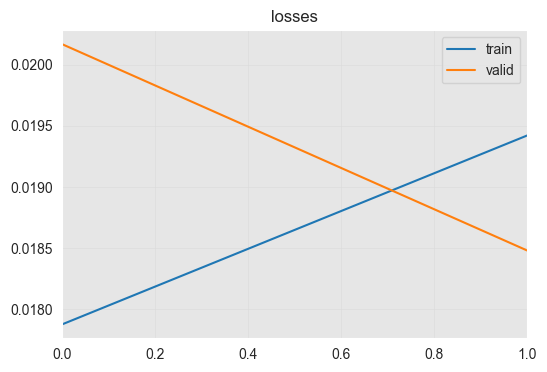

In [136]:
learn.recorder.plot_metrics()

##### Evaluation using previous approach

In [106]:
# next(iter(dls.loaders[1]))[0]

TSTensor(samples:64, vars:15, len:5, device=cuda:0, dtype=torch.float32)

In [102]:
# learn.model(next(iter(dls.loaders[0]))[0]).detach().cpu().numpy()

array([[-5.230073 ],
       [-6.585907 ],
       [-6.487775 ],
       [-3.0045776],
       [-3.9112475],
       [-5.036323 ],
       [-6.8104477],
       [-6.2172265],
       [-6.3300686],
       [-5.7532573],
       [-6.018149 ],
       [-7.1985555],
       [-5.944239 ],
       [-6.752218 ],
       [-6.0211945],
       [-6.246802 ],
       [-5.994097 ],
       [-5.663001 ],
       [-6.1089563],
       [-7.3955827],
       [-6.1270957],
       [-6.414593 ],
       [-4.590915 ],
       [-5.5511346],
       [-6.9075007],
       [-6.511906 ],
       [-6.1497   ],
       [-6.2896914],
       [-5.126823 ],
       [-7.0556245],
       [-5.741012 ],
       [-6.495129 ],
       [-6.0109725],
       [-6.3764462],
       [-6.6053395],
       [-6.683429 ],
       [-6.267901 ],
       [-7.3116918],
       [-4.6798463],
       [-4.764845 ],
       [-6.870339 ],
       [-6.411977 ],
       [-6.5825524],
       [-7.05605  ],
       [-6.135288 ],
       [-6.809913 ],
       [-6.2432256],
       [-4.32

In [101]:
# learn.model(next(iter(dls.loaders[1]))[0]).detach().cpu().numpy()

array([[-6.7172065],
       [-6.642483 ],
       [-6.5783353],
       [-6.927666 ],
       [-6.855646 ],
       [-6.696312 ],
       [-3.1947062],
       [-6.604039 ],
       [-6.841164 ],
       [-6.809047 ],
       [-6.7953234],
       [-5.0957   ],
       [-6.1537957],
       [-7.2305803],
       [-7.007545 ],
       [-6.445887 ],
       [-6.7604914],
       [-6.8918643],
       [-6.38875  ],
       [-5.6543546],
       [-6.944014 ],
       [-6.706873 ],
       [-7.065595 ],
       [-6.690906 ],
       [-6.794561 ],
       [-6.661611 ],
       [-5.7490234],
       [-6.5614295],
       [-6.841045 ],
       [-6.688557 ],
       [-6.8056784],
       [-6.845696 ],
       [-5.500777 ],
       [-6.844851 ],
       [-6.552781 ],
       [-6.698851 ],
       [-6.8862996],
       [-6.9398255],
       [-5.037219 ],
       [-6.977048 ],
       [-5.1836276],
       [-6.8645673],
       [-6.832207 ],
       [-6.913701 ],
       [-6.8968816],
       [-6.731995 ],
       [-6.714576 ],
       [-6.63

In [91]:
# learn.model.eval()
# all_preds = []
# for x_batch, _ in dls.loaders[1]:
#     y_pred = learn.model(x_batch)
#     all_preds.append(y_pred.detach().cpu().numpy())
# valid_predictions = np.vstack(all_preds)[:,0]
# valid_predictions

array([-6.7172065, -6.642483 , -6.5783353, ..., -6.2152977, -5.9031434,
       -5.9689307], dtype=float32)

##### TSAI evaluation

In [137]:
valid_dl = learn.dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(TensorBase([[0.0028],
             [0.0015],
             [0.0011],
             ...,
             [0.0007],
             [0.0015],
             [0.0017]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 TensorBase([[False],
             [False],
             [False],
             ...,
             [False],
             [False],
             [False]]))

In [139]:
valid_targets.shape, valid_preds.shape, valid_targets.long(), valid_preds.squeeze().long()

(torch.Size([58505]),
 torch.Size([58505, 1]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 TensorBase([0, 0, 0,  ..., 0, 0, 0]))

In [122]:
# Check if targets in dataframe are in the same order as in dataloader
same_order_verification_array = valid_df['TX_FRAUD'].values == valid_targets.long().numpy()
same_order_verification_array

array([ True,  True,  True, ...,  True,  True,  True])

In [125]:
assert np.count_nonzero(same_order_verification_array) == len(valid_df)

In [113]:
predictions_df = valid_df
predictions_df['predictions'] = valid_preds
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

,AUC ROC,Average precision,F1 score,Card Precision@100
0,0.779,0.47,0.67,0.227


##### Working example from tsai github issues

https://github.com/timeseriesAI/tsai/issues/406

https://github.com/timeseriesAI/tsai/issues/303

In [50]:
x_appliances, y_appliances, splits_appliances = tsai.all.get_regression_data('AppliancesEnergy', split_data=False)
print(x_appliances.shape)
print(y_appliances.shape)

(137, 24, 144)
(137,)


In [52]:
tfms_appliances  = [None, [tsai.all.TSRegression()]]
batch_tfms_appliances = tsai.all.TSStandardize(by_var=True)
dls_appliances = tsai.all.get_ts_dls(x_appliances, y_appliances, splits=splits_appliances, tfms=tfms_appliances, batch_tfms=batch_tfms_appliances)
learn_appliances = tsai.all.ts_learner(dls_appliances, tsai.all.MLSTM_FCNPlus, opt_func=tsai.all.SGD, loss_func=tsai.all.MSELossFlat(), metrics=[tsai.all.mae, tsai.all.mse])
xb_appliances, yb_appliances = dls_appliances.train.one_batch()
learn_appliances.model.backbone(xb_appliances).shape

torch.Size([64, 228])

In [61]:
next(iter(dls_appliances.loaders[0]))

(TSTensor(samples:64, vars:24, len:144, device=cuda:0, dtype=torch.float32),
 tensor([22.1000, 10.5100, 21.7400, 21.3100, 11.8300, 14.6200, 17.5300, 11.3200,
         13.6900, 10.4600, 12.2400,  8.7500, 10.6100, 21.6900, 11.6400, 19.3800,
         23.0100, 13.8700, 14.9900, 10.2600, 16.2500, 14.8200, 12.0700, 19.6200,
         21.4900, 10.1100, 16.5300, 16.0500, 16.7700, 12.0300, 17.0000, 14.7100,
         26.2800,  9.1700, 12.7200, 12.6800, 10.5100, 10.8000,  9.9900, 11.5300,
         21.9100, 18.1800, 14.2800, 11.6300, 11.5400, 16.4100,  8.6200, 12.9800,
         10.8200,  5.3800, 15.8900, 10.3100, 13.2500, 15.6800, 20.4400, 13.3700,
         13.5600, 10.2500, 17.3000, 18.5600, 19.0100, 10.8900, 10.1700, 11.9200],
        device='cuda:0'))

In [67]:
learn_appliances.fit_one_cycle(1)

epoch,train_loss,valid_loss,mae,mse,time
0,191.030579,201.919312,13.788134,201.919312,00:00
